<center>

# DATA PROCESS 

</center>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import requests
import numpy as np
from urllib.parse import quote
from dotenv import load_dotenv

In [16]:
api_key = os.environ.get('riot_api_key')
gameName='C9 Loki'
tagLine='kr3'
encoded_gameName = quote(gameName)
def get_puuid(encoded_gameName= None, tagLine= None, api_key =None):
    link = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{encoded_gameName}/{tagLine}?api_key={api_key}'
    response = requests.get(link)
    return response.json()['puuid']

def get_ladder():
    root= 'https://na1.api.riotgames.com/'
    chall ='lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'
    gm='lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5'
    masters= 'lol/league/v4/masterleagues/by-queue/RANKED_SOLO_5x5'

    chall_response = requests.get(root + chall + '?api_key=' + api_key)
    gm_response = requests.get(root + gm + '?api_key=' + api_key)
    masters_response = requests.get(root + masters + '?api_key=' + api_key)

    chall_df = pd.DataFrame(chall_response.json()['entries'])
    gm_df = pd.DataFrame(gm_response.json()['entries'])
    masters_df = pd.DataFrame(masters_response.json()['entries'])
    ladder = pd.concat([chall_df,gm_df,masters_df])[0:3].reset_index(drop=True)
    ladder = ladder.drop(columns='rank').reset_index(drop=False).rename(columns={'index':'rank'})
    ladder['rank'] += 1
    return ladder
get_ladder()


,rank,summonerId,puuid,leaguePoints,wins,losses,veteran,inactive,freshBlood,hotStreak
0,1,VpOXU5hy0nHly6vHcEkAo7gyGzU7HT7lD7a1_QGZPill1B...,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,2055,244,153,True,False,False,False
1,2,QfhAYG8NzPardb0lGp-LwP-EwT4n1nAz-bTXJwWWnvH1Svg,Bb79SpPa7Kgp8v4xDIoeWAIxhfQxLEnuQxqHod_BnopMf5...,1937,218,152,True,False,False,False
2,3,SUTwQ0pFWxFUD3-U3ytXfWScuZqXbWC6ZAHcFlDuewX8UO...,NPNPxUpG8efhIvKFiniK_YTCgEnHyVMQmFh7jiqE9exdxh...,1883,144,82,True,False,False,False


Riot developer tool provides high elo players' information. I wrote a get_ladder function to store challanger player's information.

In [ ]:
df = get_ladder()
df = df[['summonerId', 'puuid', 'leaguePoints', 'wins', 'losses', 
         'veteran', 'inactive', 'freshBlood', 'hotStreak']]
df.to_csv('ladder_puuids.csv', index=False)
df = pd.read_csv('ladder_puuids.csv')
puuids = df['puuid'].tolist()
puuids

['cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3KkpqttpPDoL-cbd-yns_mEm6zEN1YpS-19iVc8w',
 'Bb79SpPa7Kgp8v4xDIoeWAIxhfQxLEnuQxqHod_BnopMf50ViqfC4OFKimDBeZ02O_-RhSbcncdOyw',
 'NPNPxUpG8efhIvKFiniK_YTCgEnHyVMQmFh7jiqE9exdxh7zX7y9mbrX2epFehNYfPPeoioBLWixRQ']

I extracted the puuids of high elo players, so that I can interact players one by one to get match_ids.

In [41]:
def get_match_history(region=None, puuid=None, start=0, count=50, queue=420):
    root_url = f'https://{region}.api.riotgames.com'
    endpoint = f'/lol/match/v5/matches/by-puuid/{puuid}/ids'
    query_params = f'?start={start}&count={count}&queue={queue}'
    response = requests.get(root_url + endpoint + query_params + '&api_key=' + api_key)
    return response.json()

def get_match_data_from_id(region= None,matchId=None):
    root_url= f'https://{region}.api.riotgames.com/'
    endpoint = f'/lol/match/v5/matches/{matchId}'

    response = requests.get(root_url + endpoint  +'?api_key=' +api_key)
    return response.json()

data = get_match_data_from_id(region='americas', matchId='NA1_5274110401')


get_match_history takes the puuid and returns list of match_ids. I can choose how many matches I want to get.
get_match_data_from_id return the raw data that includes everything related to the given match_id.

In [ ]:
def process_match_json(match_json, puuid):

    side_dict = {
        100:'blue',
        200:'red'
    }

    try:
        info = match_json['info']


        metadata = match_json['metadata']
        matchId = metadata['matchId']
        participants = metadata['participants']

        player = info['participants'][participants.index(puuid)]
        gameStartTimestamp = info['gameStartTimestamp']
        gameEndTimestamp = info['gameEndTimestamp']
        timePlayed = int((gameEndTimestamp-gameStartTimestamp)/1000//60)
        puuid = player['puuid']
  
        try:
            riotIdTagLine = player['riotIdTagline']
        except:
            riotIdTagLine = ''
        side = side_dict[player['teamId']]
        win = player['win']
        surrender = player['gameEndedInSurrender']
        totalMinionsKilled = player['totalMinionsKilled']
        totalDamageDealtToChampions = player['totalDamageDealtToChampions']
        visionScore = player['visionScore']

        matchDF = pd.DataFrame({
            'match_id': [matchId],
            'puuid': [puuid],
            'win': [win],
            'total_minions_killed': [totalMinionsKilled],
            'surrender': [surrender],
            'total_damage_dealt_champions': [totalDamageDealtToChampions],
            'vision_score': [visionScore],
            'time_played':[timePlayed],

        })
    
        return matchDF
    except:
        return pd.DataFrame()

process_match_json processes the raw data. I can manipulate it to process any parameter I want.

In [ ]:
all_rows = []
puuidlist=['cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3KkpqttpPDoL-cbd-yns_mEm6zEN1YpS-19iVc8w']
request_count=0
for puuid in puuidlist:
    match_ids = get_match_history(region='americas',puuid=puuid,start=0, count=3) 
    request_count += 1
    time.sleep(1)

    for match_id in match_ids:
        try:
            match_json = get_match_data_from_id("americas", match_id)
            match_df = process_match_json(match_json, puuid)

            if not match_df.empty:
                all_rows.append(match_df)
            
            request_count+=1
            time.sleep(0.2)
            if request_count >= 95:
                print('Waiting for 2 min')
                time.sleep(120)
                request_count=0

        except Exception as e:
            print(f"Error with match {match_id} for puuid {puuid}: {e}")


df = pd.concat(all_rows, ignore_index=True)
print(f"Final dataframe shape: {df.shape}")
df['minionsPerMinute'] = (df['total_minions_killed'] / df['time_played']).round(2)
df['visionScorePerMinute'] = (df['vision_score'] / df['time_played']).round(2)
df['damageDealtPerMinute'] = (df['total_damage_dealt_champions'] / df['time_played']).round(2)
df #df.to_csv('challanger_data.csv', index=False)

Final dataframe shape: (3, 8)


,match_id,puuid,win,total_minions_killed,surrender,total_damage_dealt_champions,vision_score,time_played,minionsPerMinute,visionScorePerMinute,damageDealtPerMinute
0,NA1_5274110401,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,True,225,False,39953,33,35,6.43,0.94,1141.51
1,NA1_5274081875,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,True,161,True,14755,12,18,8.94,0.67,819.72
2,NA1_5273518673,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,False,324,False,42742,37,37,8.76,1.00,1155.19


In order to process low elo matches, I used op.gg to get low elo players' nicknames and taglines. After that, I got their puuids by using my functions, and made a list.

I processed the parameters as per-minute ratios to prevent long games from causing misinterpretation.

Matches that ended early due to an AFK player were treated as outliers and removed, as they do not accurately represent player performance.

During data collection, I ensured an equal distribution of roles between Challenger and low elo matches to avoid bias. An imbalance, such as having more support players, could distort the findings.

I also added my own match data to make it more interesting.


<center>

# Exploratory Data Analysis and Visualization

</center>

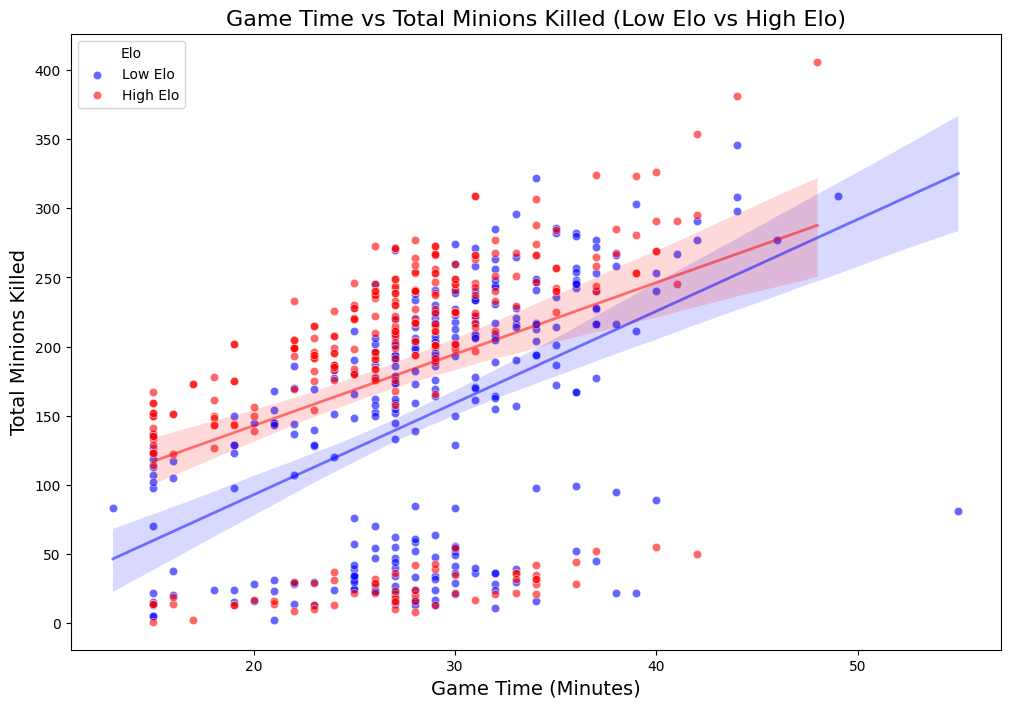

In [42]:
low_elo_df = pd.read_csv('low_elo_data.csv')  
high_elo_df = pd.read_csv('challenger_data.csv')  
plt.figure(figsize=(12, 8))
sns.scatterplot(x='time_played', y='total_minions_killed', data=low_elo_df, color='blue', label='Low Elo', alpha=0.6)
sns.scatterplot(x='time_played', y='total_minions_killed', data=high_elo_df, color='red', label='High Elo', alpha=0.6)
sns.regplot(x='time_played', y='total_minions_killed', data=low_elo_df, scatter=False, color='blue', line_kws={"color": "blue", "alpha": 0.5, "lw": 2})
sns.regplot(x='time_played', y='total_minions_killed', data=high_elo_df, scatter=False, color='red', line_kws={"color": "red", "alpha": 0.5, "lw": 2})

plt.title('Game Time vs Total Minions Killed (Low Elo vs High Elo)', fontsize=16)
plt.xlabel('Game Time (Minutes)', fontsize=14)
plt.ylabel('Total Minions Killed', fontsize=14)
plt.legend(title="Elo", loc='upper left')

plt.show()

High elo players are more skilled and consistent at slaying minions compared to low elo players. Low elo players often struggle with last-hitting in the early game, as it requires precise timing and mechanics. In the late game, however, they can one-shot minions more easily, which helps close the gap. Despite this, Challenger players still outperform low elo players in minion kills throughout all phases of the game.

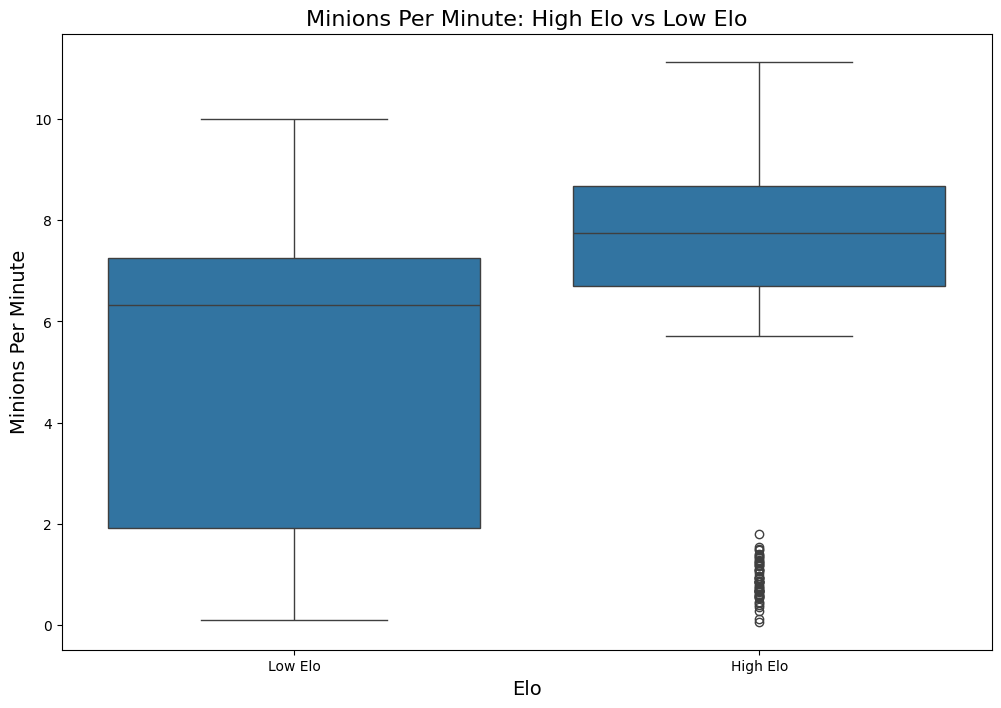

In [50]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['minionsPerMinute', 'elo']], 
                         high_elo_df[['minionsPerMinute', 'elo']]])

plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='minionsPerMinute', data=combined_df)
plt.title('Minions Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Minions Per Minute', fontsize=14)
plt.show()

Overall, high elo players consistently perform well in farming minions, with support players being the main outliers, as they tend to slay fewer minions. On the other hand, the mean and median values for low elo players are relatively low. This means high elo players earn more gold and buy better items.

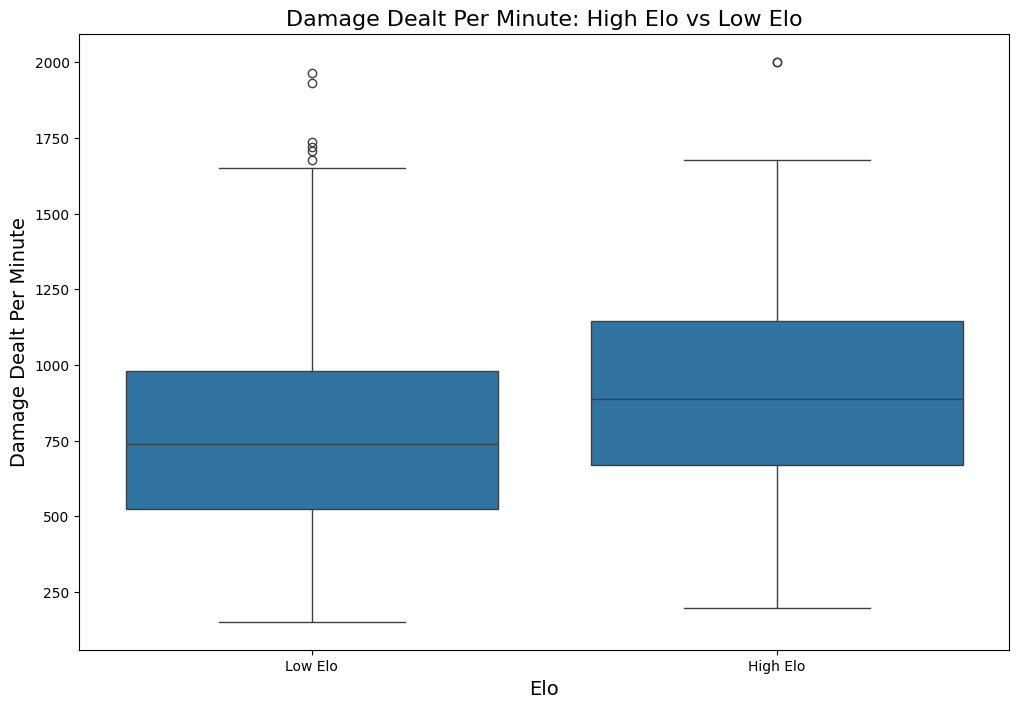

In [43]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['damageDealtPerMinute', 'elo']], 
                         high_elo_df[['damageDealtPerMinute', 'elo']]])
plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='damageDealtPerMinute', data=combined_df)
plt.title('Damage Dealt Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Damage Dealt Per Minute', fontsize=14)

plt.show()

High Elo players are more consistent in dealing damage. In low Elo games, there is an imbalance and variability in damage dealt. High Elo players tend to have both higher averages and medians, indicating more reliable and effective performance across matches.

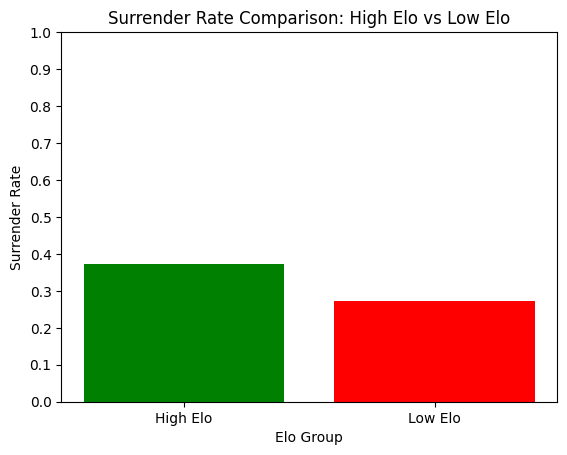

In [46]:
high_elo_surrender_rate = high_elo_df['surrender'].mean()
low_elo_surrender_rate = low_elo_df['surrender'].mean()
elo_groups = ['High Elo', 'Low Elo']
surrender_rates = [high_elo_surrender_rate, low_elo_surrender_rate]
plt.bar(elo_groups, surrender_rates, color=['green', 'red'])
plt.title('Surrender Rate Comparison: High Elo vs Low Elo')
plt.ylabel('Surrender Rate')
plt.xlabel('Elo Group')
plt.ylim(0, 1)  # Ensure the y-axis is from 0 to 1
plt.yticks(np.arange(0, 1.1, 0.1))  # Set ticks at intervals of 0.1 (0.0, 0.1, 0.2, ..., 1.0)

plt.show()

When it comes to surrender rates, Challenger players outperform low Elo players. Their ability to read the game allows them to recognize unwinnable situations and avoid wasting time. In contrast, low Elo players are more likely to avoid surrendering, continuing to play even when the odds of winning are extremely low.

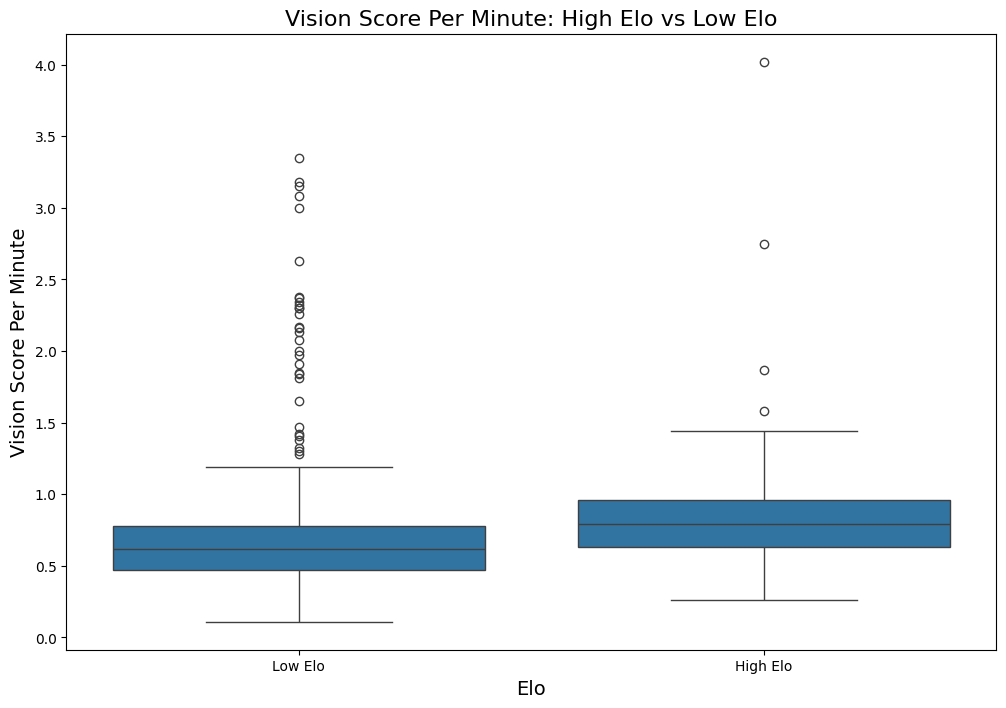

In [47]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['visionScorePerMinute', 'elo']], 
                         high_elo_df[['visionScorePerMinute', 'elo']]])
plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='visionScorePerMinute', data=combined_df)
plt.title('Vision Score Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Vision Score Per Minute', fontsize=14)

plt.show()

Vision scores reflect a major gap in awareness between high and low Elo players. In high Elo, players across all roles consistently contribute to vision control, showing a clear understanding of its importance. In contrast, low Elo matches often rely solely on support players for vision, creating outliers while the overall average remains low. This suggests a lack of shared responsibility and game awareness in lower tiers.

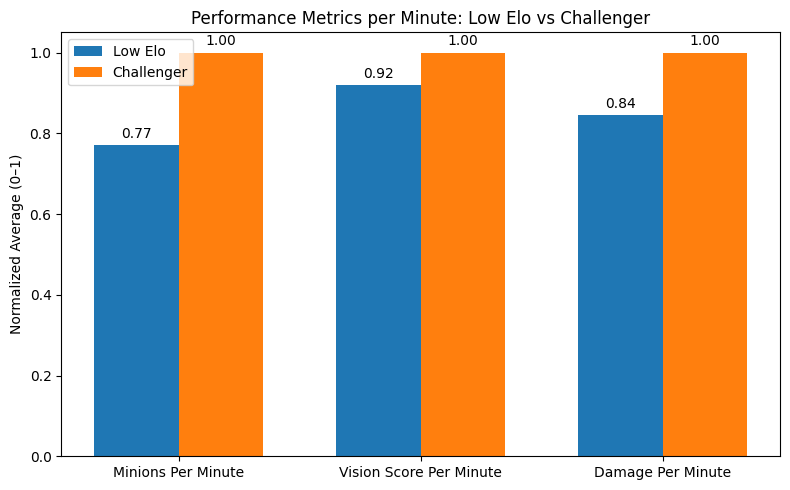

In [49]:
low_elo = pd.read_csv("low_elo_data.csv")
challenger = pd.read_csv("challenger_data.csv")
metrics = {
    "Minions Per Minute": [
        low_elo["minionsPerMinute"].mean(),
        challenger["minionsPerMinute"].mean()
    ],
    "Vision Score Per Minute": [
        low_elo["visionScorePerMinute"].mean(),
        challenger["visionScorePerMinute"].mean()
    ],
    "Damage Per Minute": [
        low_elo["damageDealtPerMinute"].mean(),
        challenger["damageDealtPerMinute"].mean()
    ]
}
normalized = {key: [val / max(vals) for val in vals] for key, vals in metrics.items()}
labels = list(normalized.keys())
low = [v[0] for v in normalized.values()]
high = [v[1] for v in normalized.values()]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, low, width, label='Low Elo')
bars2 = ax.bar(x + width/2, high, width, label='Challenger')
ax.set_ylabel('Normalized Average (0–1)')
ax.set_title('Performance Metrics per Minute: Low Elo vs Challenger')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.show()

It is evident that high elo players are more efficient and outperform low elo players in every category. They are more skilled at last-hitting minions, more aware of vision control, and deal more damage to the enemy team per minute.

<center>

# Hypothesis Testing

</center>
